# Survival Analysis

In [ ]:
pip install miceforest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.2 MB/s eta 0:00:00


In [1]:
# Import neccessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import miceforest as mf

# Strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion..
from sklearn.impute import KNNImputer

## Read Dataset

In [4]:
df = pd.read_csv('../data/train.csv')

In [5]:
# head
df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


## Overview of the Data

In [7]:
# info.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

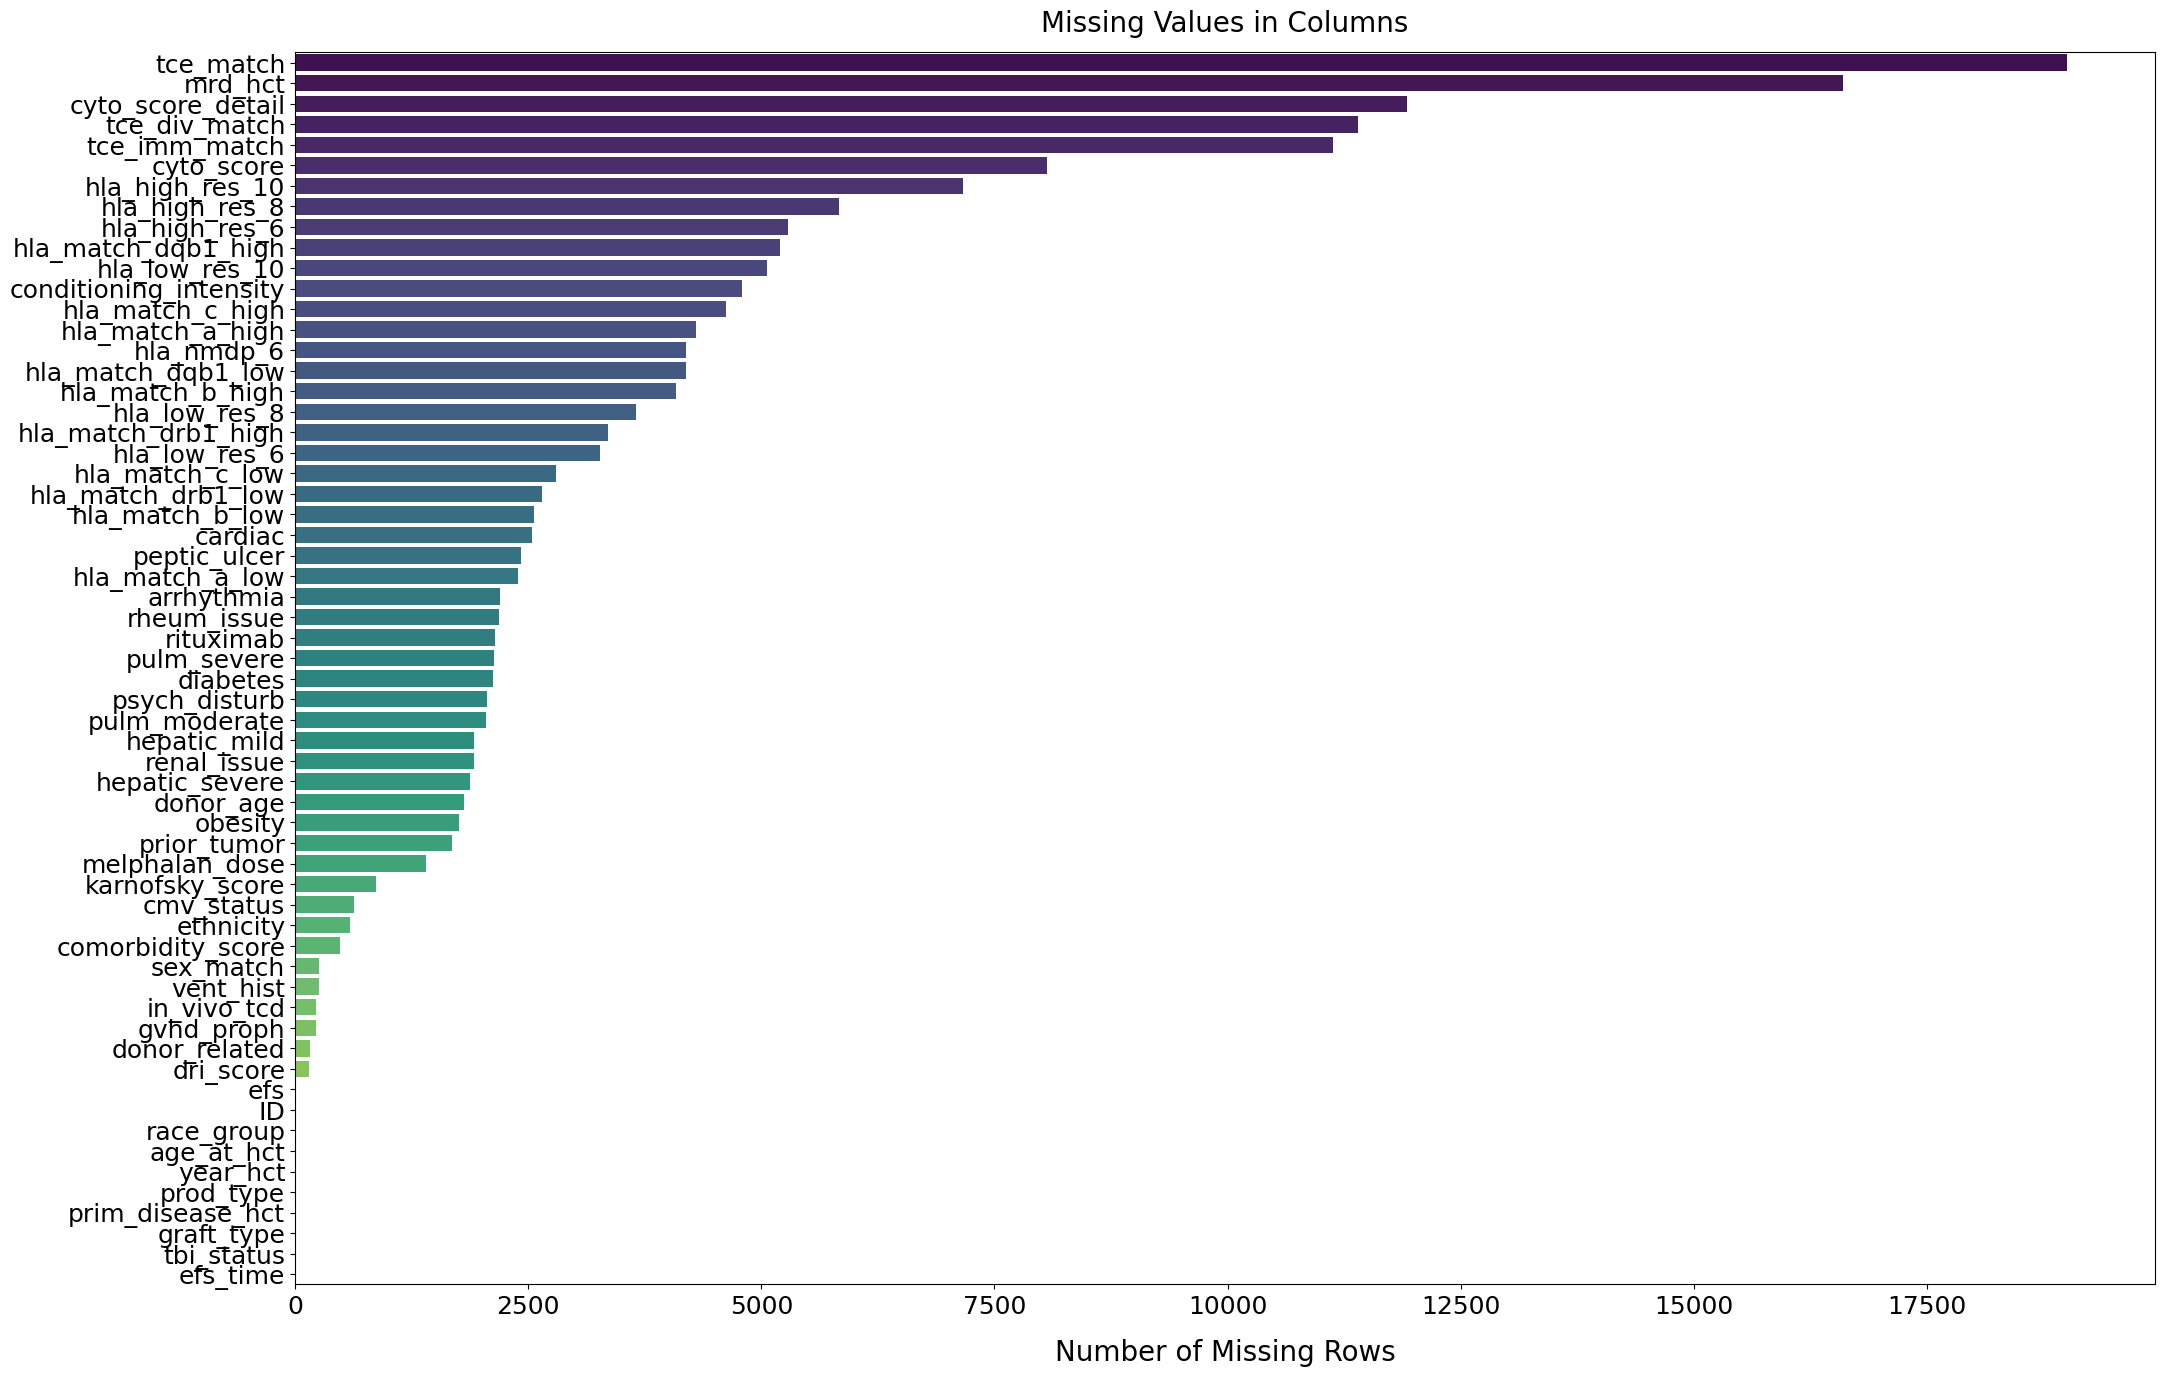

In [8]:
# Finding missing values.
fig = plt.figure(figsize=(24, 16))

sns.barplot(x=df.isnull().sum().sort_values(ascending=False).values,
            y=df.isnull().sum().sort_values(ascending=False).index,
            hue=df.isnull().sum().sort_values(ascending=False).index,
            palette='viridis',
            )

plt.xlabel('Number of Missing Rows', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Missing Values in Columns', size=20, pad=15)

plt.show()

There are 59 columns and only 10 columns don't have missing values in them. Most importantly, there are no missing values in time-to-event, event indicator.

In [9]:
# Find the percentage of missing values.
df.isnull().sum() / df.shape[0] * 100

ID                         0.000000
dri_score                  0.534722
psych_disturb              7.159722
cyto_score                28.013889
diabetes                   7.357639
hla_match_c_high          16.041667
hla_high_res_8            20.239583
tbi_status                 0.000000
arrhythmia                 7.645833
hla_low_res_6             11.354167
graft_type                 0.000000
vent_hist                  0.899306
renal_issue                6.649306
pulm_severe                7.413194
prim_disease_hct           0.000000
hla_high_res_6            18.347222
cmv_status                 2.201389
hla_high_res_10           24.871528
hla_match_dqb1_high       18.052083
tce_imm_match             38.656250
hla_nmdp_6                14.572917
hla_match_c_low            9.722222
rituximab                  7.458333
hla_match_drb1_low         9.177083
hla_match_dqb1_low        14.562500
prod_type                  0.000000
cyto_score_detail         41.399306
conditioning_intensity    16

In [10]:
# finding duplicates
df.duplicated().sum()

0

In [11]:
# identifying garbage values (form of object data type)
for i in df.select_dtypes(include='object').columns:
    print(df[i].value_counts()) # Give the count of each unique value in the column.
    print("***"*10)

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing disease status                                   9
Name: count, dtype: int64
******************************
psych_disturb
No          23005
Yes          3587
Not done      146
Name: count, dtype: int64
******************************
cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
N

## Exploratory Data Analysis

In [12]:
# descriptive statistics.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,28800.0,14399.500000,8313.988213,0.000,7199.75000,14399.5000,21599.25000,28799.000
hla_match_c_high,24180.0,1.764516,0.431941,0.000,2.00000,2.0000,2.00000,2.000
hla_high_res_8,22971.0,6.876801,1.564313,2.000,6.00000,8.0000,8.00000,8.000
hla_low_res_6,25530.0,5.143322,1.207757,2.000,4.00000,6.0000,6.00000,6.000
hla_high_res_6,23516.0,5.109202,1.214162,0.000,4.00000,6.0000,6.00000,6.000
hla_high_res_10,21637.0,8.617230,1.905125,3.000,7.00000,10.0000,10.00000,10.000
hla_match_dqb1_high,23601.0,1.736876,0.447687,0.000,1.00000,2.0000,2.00000,2.000
hla_nmdp_6,24603.0,5.160346,1.203240,2.000,4.00000,6.0000,6.00000,6.000
hla_match_c_low,26000.0,1.757808,0.435453,0.000,2.00000,2.0000,2.00000,2.000
hla_match_drb1_low,26157.0,1.715296,0.451282,1.000,1.00000,2.0000,2.00000,2.000


In [15]:
df.describe(include='object').T

,count,unique,top,freq
dri_score,28646,11,Intermediate,10436
psych_disturb,26738,3,No,23005
cyto_score,20732,7,Poor,8802
diabetes,26681,3,No,22201
tbi_status,28800,8,No TBI,18861
arrhythmia,26598,3,No,25203
graft_type,28800,2,Peripheral blood,20546
vent_hist,28541,2,No,27721
renal_issue,26885,3,No,26548
pulm_severe,26665,3,No,24779


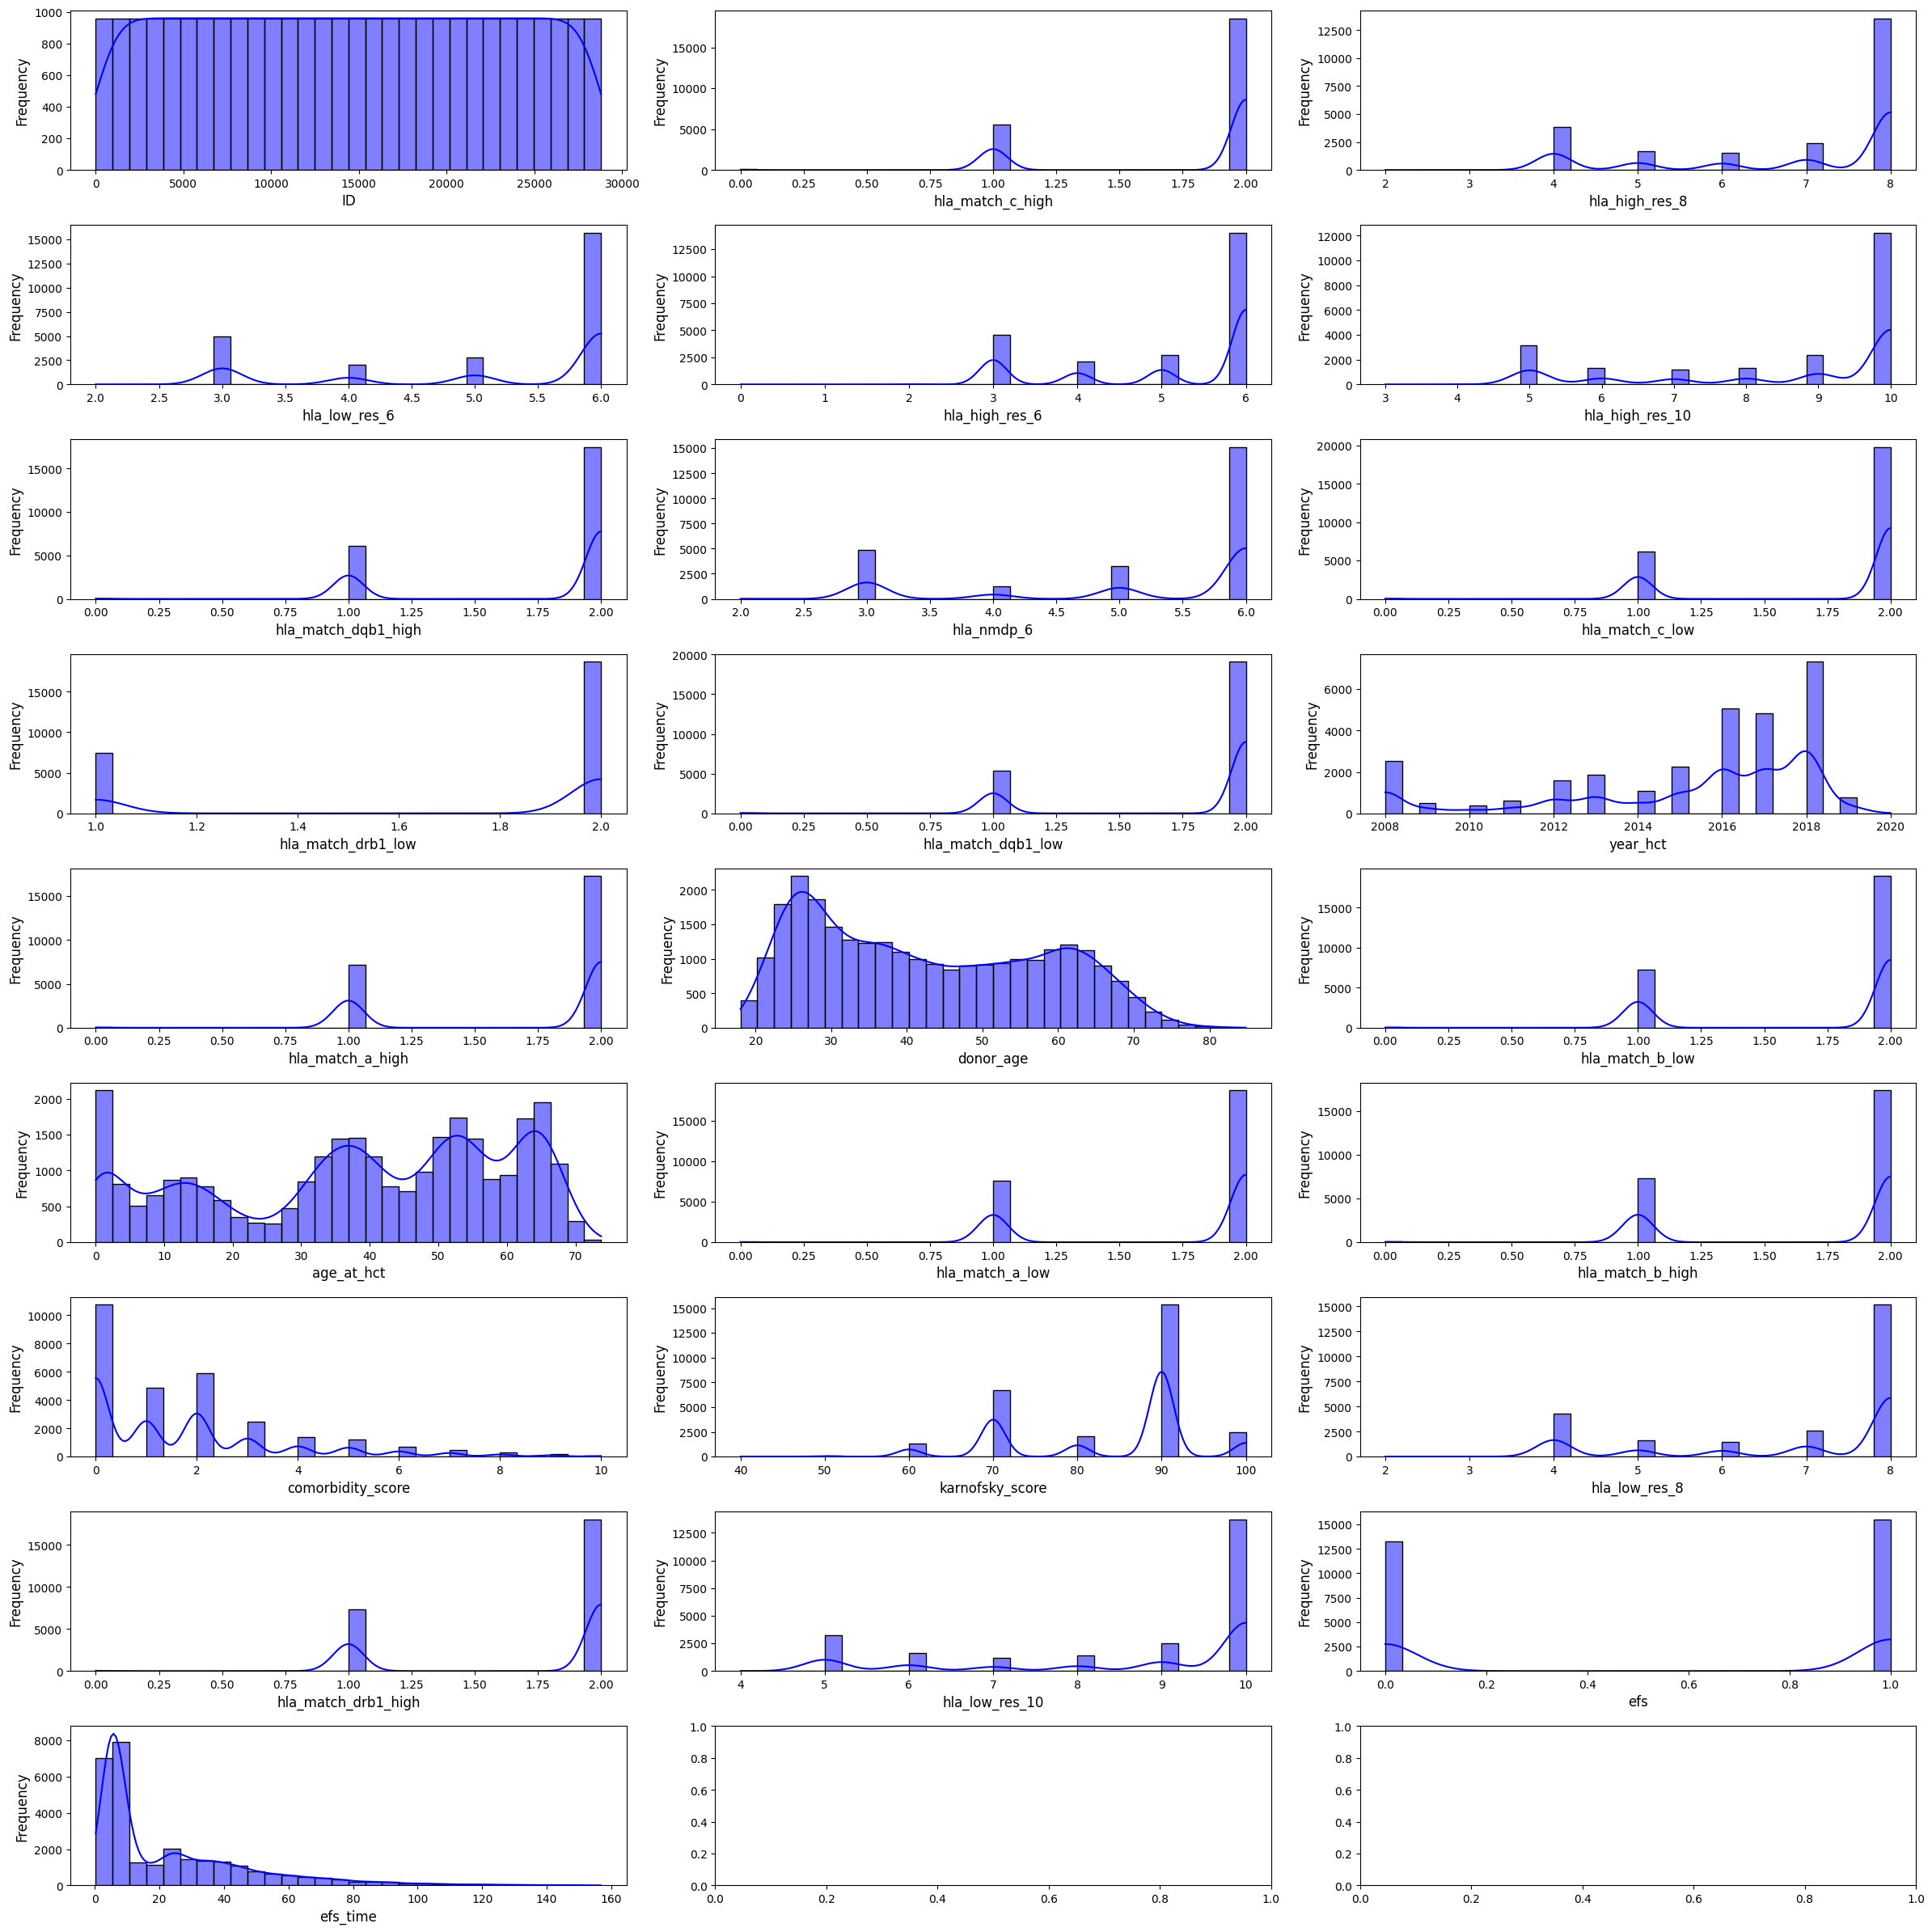

In [16]:
# use histogram to understand the distribution of the data.
num_cols = len(df.select_dtypes(include='number').columns)
num_rows = (num_cols // 3) + (num_cols % 3 > 0)

fig, axes = plt.subplots(num_rows, 3, figsize=(24, 24))

for i, col in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i // 3, i % 3]  # Properly index the subplot grid
    sns.histplot(df[col], kde=True, color='blue', bins=30, ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

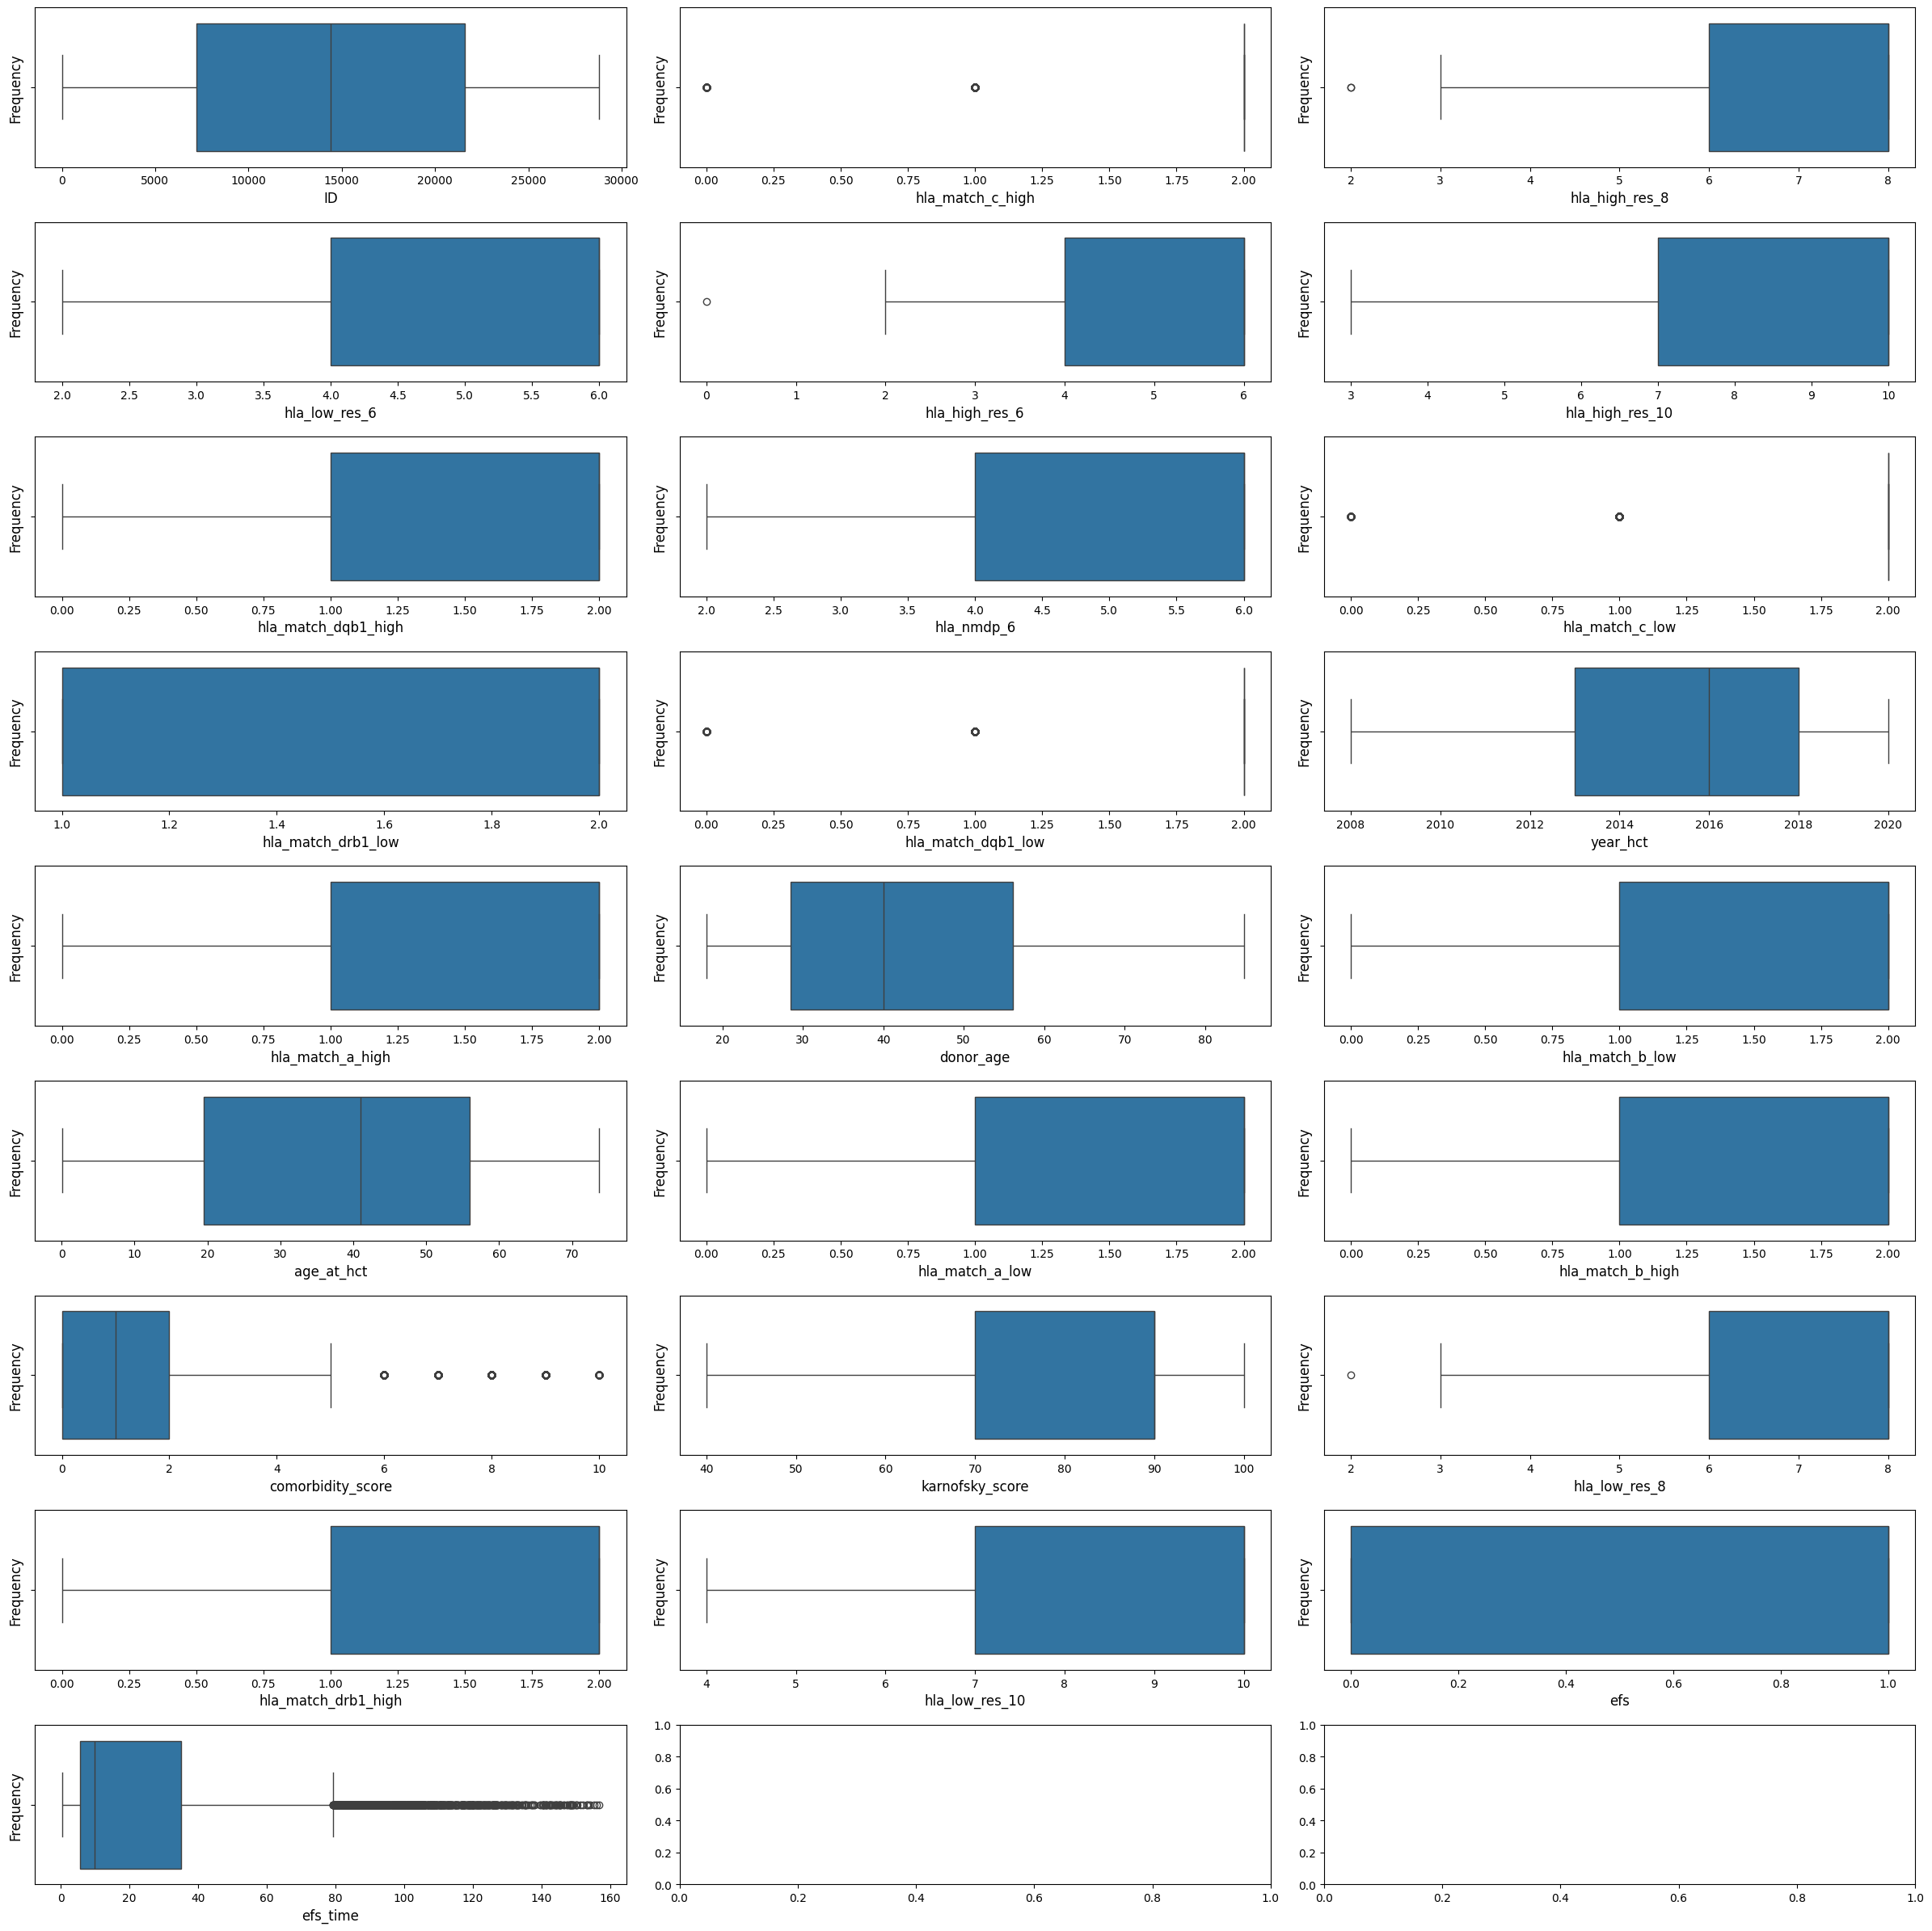

In [ ]:
# use boxplot to understand to check for outliers.
fig, axes = plt.subplots(num_rows, 3, figsize=(24, 24))

for i, col in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i // 3, i % 3]  # Properly index the subplot grid
    sns.boxplot(data=df, x=col, ax=ax)  # Pass the column name and specify the axis
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

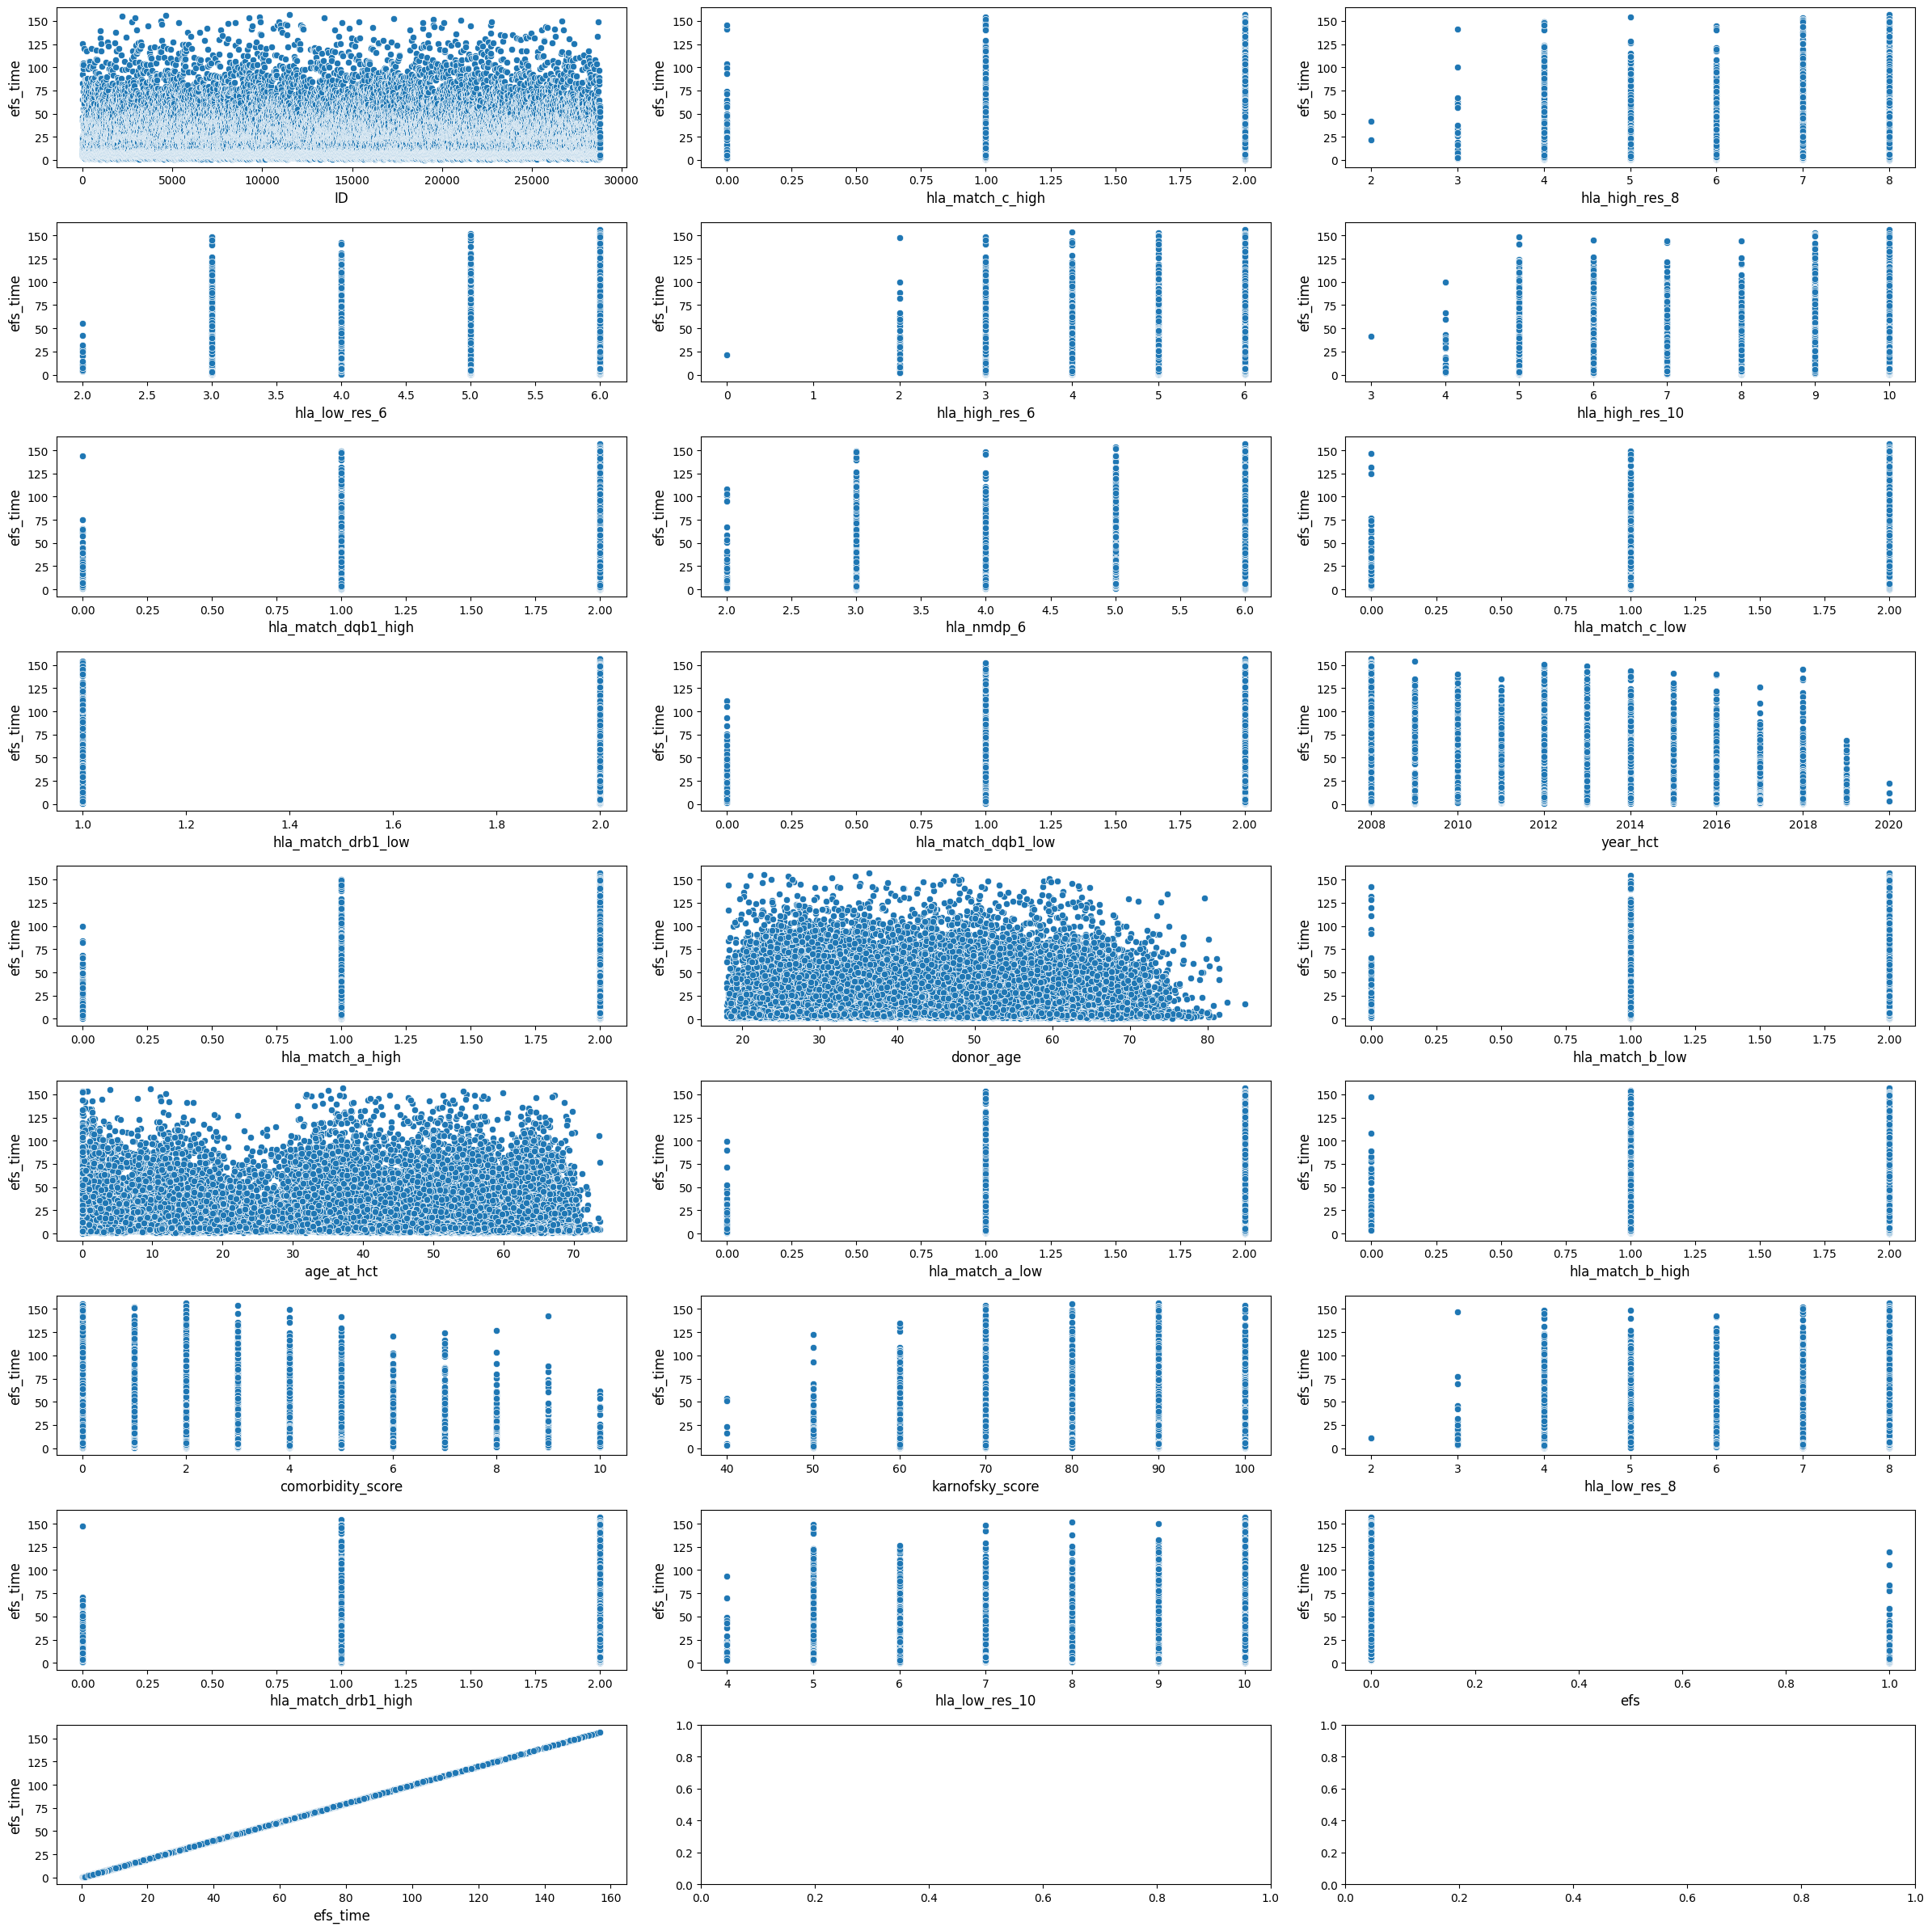

In [19]:
# scatter the plot to understand the relationship between the features.
fig, axes = plt.subplots(num_rows, 3, figsize=(24, 24))

for i, col in enumerate(df.select_dtypes(include='number').columns):
    ax = axes[i // 3, i % 3]  # Properly index the subplot grid
    sns.scatterplot(data=df, x=col, y='efs_time', ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('efs_time', fontsize=12)

plt.tight_layout()
plt.show()

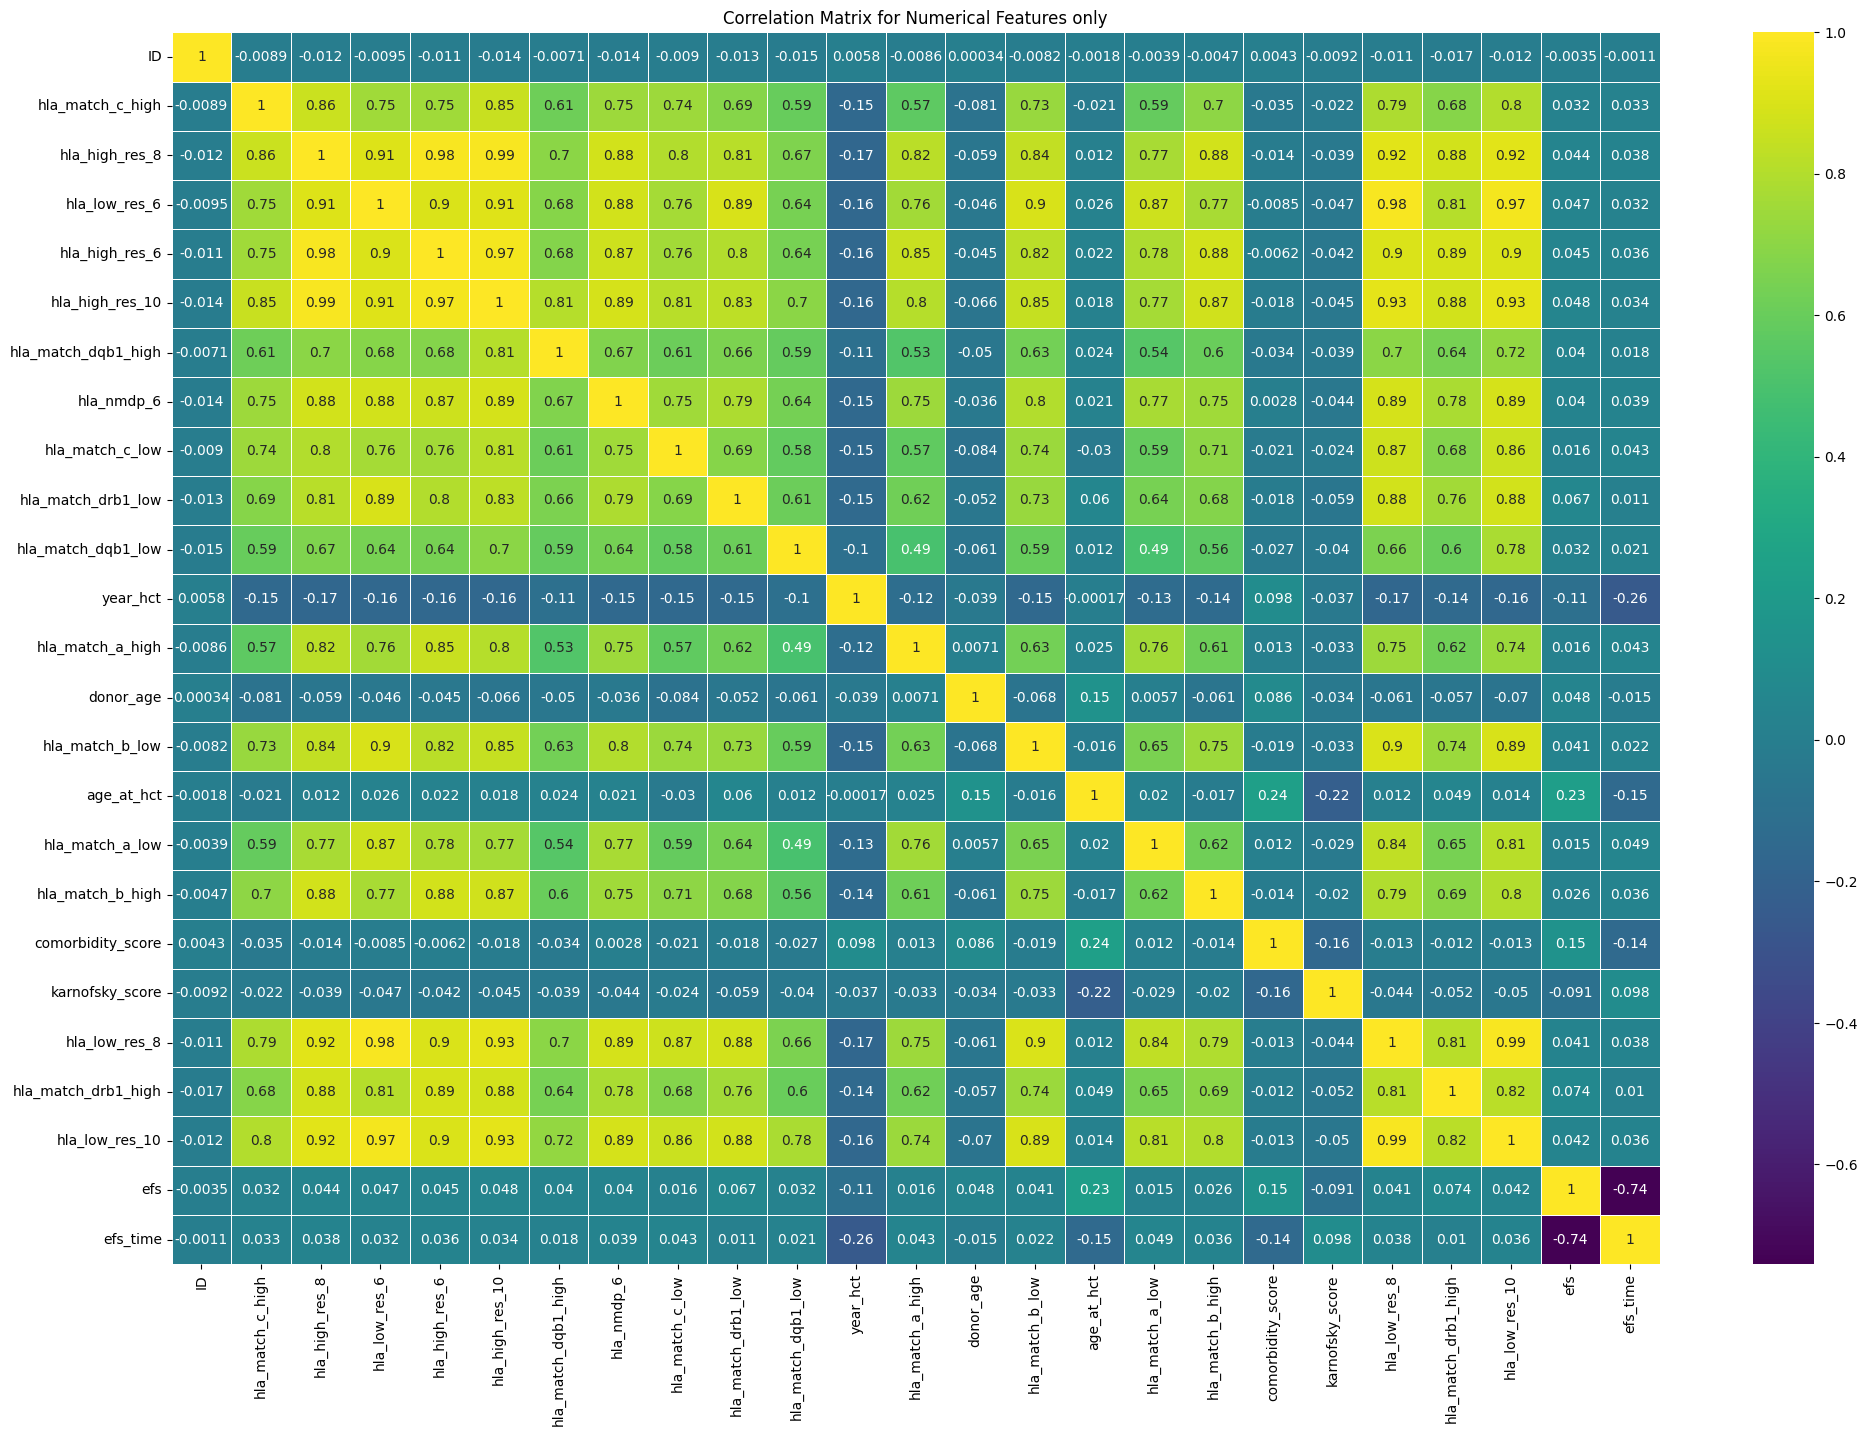

In [20]:
# Let's compute the correlation matrix for numerical features (excluding categorical and highly missing ones).
numerical_features = df.select_dtypes(include='number')
correlation_matrix = numerical_features.corr()

# Visualizing the correlation matrix.
plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix for Numerical Features only')
plt.show()

HLA features are moderately correlated, we can assume that the model will predict good results with those features.

In [21]:
## Missing Values Treatment
df.isnull().sum()

ID                            0
dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2202
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
year_hct                      0
obesity                    1760
mrd_hct 

Missing numerical values are discrete. Replacing them with mean, median is not possible. Mode can be a solution here.

In [22]:
## Missing Values Treatment
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.isnull().sum()

ID                        0
hla_match_c_high       4620
hla_high_res_8         5829
hla_low_res_6          3270
hla_high_res_6         5284
hla_high_res_10        7163
hla_match_dqb1_high    5199
hla_nmdp_6             4197
hla_match_c_low        2800
hla_match_drb1_low     2643
hla_match_dqb1_low     4194
year_hct                  0
hla_match_a_high       4301
donor_age              1808
hla_match_b_low        2565
age_at_hct                0
hla_match_a_low        2390
hla_match_b_high       4088
comorbidity_score       477
karnofsky_score         870
hla_low_res_8          3653
hla_match_drb1_high    3352
hla_low_res_10         5064
efs                       0
efs_time                  0
dtype: int64

In [23]:
# Create the Kernel (MICE model)
kernel = mf.ImputationKernel(
    numerical_features,
    num_datasets=10,
    random_state=42
)

# Perform imputation
kernel.mice(5) # 5 iterations of imputation

imputed_df = kernel.complete_data()

imputed_df.head()

NameError: name 'mf' is not defined

In [24]:
df[numerical_features.columns] = imputed_df[numerical_features.columns]
df.isnull().sum() / df.shape[0] * 100

NameError: name 'imputed_df' is not defined

We will try 3 different datasets. First one conserves all the columns but missing values have been imputed with 'unknown' value. Second, missing values have been imputed with mode. Eventually, last one deletes complete columns in which missing values' rate is over 50%. Remaining missing values are filled with mode.

In [ ]:
df_impute_missing_with_unknown_cat = df.copy()
df_impute_missing_with_mode = df.copy()
df_delete_huge_missing_col = df.copy()

In [ ]:
# Impute missing values in categorical columns with 'Unknown'.
df_impute_missing_with_unknown_cat.fillna('Unknown', inplace=True)
df_impute_missing_with_unknown_cat.isnull().sum() / df_impute_missing_with_unknown_cat.shape[0] * 100
#df_impute_missing_with_unknown_cat.shape

In [ ]:
# Impute missing values in categorical columns with the mode.
df_impute_missing_with_mode.fillna(df_impute_missing_with_mode.mode().iloc[0], inplace=True)
df_impute_missing_with_mode.isnull().sum() / df_impute_missing_with_mode.shape[0] * 100
#df_impute_missing_with_mode.shape

In [ ]:
# Remove columns with more than 50% missing values
df_delete_huge_missing_col.dropna(axis=1, thresh=0.5*df_delete_huge_missing_col.shape[0], inplace=True)

# Impute missing values in numerical columns with the mode.
df_impute_missing_with_mode.fillna(df_impute_missing_with_mode.mode().iloc[0], inplace=True)
df_impute_missing_with_mode.isnull().sum() / df_impute_missing_with_mode.shape[0] * 100
#df_impute_missing_with_mode.shape

In [ ]:
"""
# Remove columns with missing values over 50% and remove rows with missing values less than 5%
df_delete_huge_missing_col.dropna(axis=1, thresh=0.4*df.shape[0], inplace=True)

for col in df.columns:
    if df_delete_huge_missing_col[col].isna().mean() < 0.05:
        df_delete_huge_missing_col = df_delete_huge_missing_col.dropna(subset=[col])
"""

In [ ]:
# Download the csv.
df_impute_missing_with_mode.to_csv('with_mode.csv', index=False)
df_impute_missing_with_unknown_cat.to_csv('with_unknown.csv', index=False)
df_delete_huge_missing_col.to_csv('missing_col.csv', index=False)